## Step 1: Load and Inspect the Dataset

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
import xgboost as xgb 
import pandas as pd


In [266]:


# Load dataset
df = pd.read_csv('../data/personality_dataset.csv')

# Basic inspection
print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (2900, 8)


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


## Step 2: Explore the Data (Column Types & Cleaning)


In [267]:
# Check for missing values and data types
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2900 non-null   float64
 1   Stage_fear                 2900 non-null   object 
 2   Social_event_attendance    2900 non-null   float64
 3   Going_outside              2900 non-null   float64
 4   Drained_after_socializing  2900 non-null   object 
 5   Friends_circle_size        2900 non-null   float64
 6   Post_frequency             2900 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB


Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

In [268]:
df.columns

Index(['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')

In [269]:
df.dtypes

Time_spent_Alone             float64
Stage_fear                    object
Social_event_attendance      float64
Going_outside                float64
Drained_after_socializing     object
Friends_circle_size          float64
Post_frequency               float64
Personality                   object
dtype: object

In [270]:
df.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,2900.000000,2900.000000,2900.000000,2900.000000,2900.000000
mean,4.505816,3.963354,3.000000,6.268863,3.564727
std,3.441180,2.872608,2.221597,4.232340,2.893587
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,1.000000,3.000000,1.000000
50%,4.000000,3.963354,3.000000,5.000000,3.000000
75%,7.000000,6.000000,5.000000,10.000000,6.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


In [271]:
print("Unique values in 'Stage_fear':")
print(df['Stage_fear'].unique())

print("\nUnique values in 'Drained_after_socializing':")
print(df['Drained_after_socializing'].unique())

print("\nValue counts for 'Personality':")
print(df['Personality'].value_counts())

# Data looks clean right from the beginning... sus

Unique values in 'Stage_fear':
['No' 'Yes']

Unique values in 'Drained_after_socializing':
['No' 'Yes']

Value counts for 'Personality':
Personality
Extrovert    1491
Introvert    1409
Name: count, dtype: int64


In [272]:
# Create helper columns for plotting with labels
df['Personality_label'] = df['Personality']
df['Stage_fear_label'] = df['Stage_fear']
df['Drained_after_socializing_label'] = df['Drained_after_socializing'] 

# Map Yes/No to 1/0
df['Stage_fear'] = df['Stage_fear'].map({'Yes': 1, 'No': 0})
df['Drained_after_socializing'] = df['Drained_after_socializing'].map({'Yes': 1, 'No': 0})

# Map Personality to 1/0
df['Personality'] = df['Personality'].map({'Extrovert': 1, 'Introvert': 0})

# Confirm the changes
df.head()


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality,Personality_label,Stage_fear_label,Drained_after_socializing_label
0,4.0,0,4.0,6.0,0,13.0,5.0,1,Extrovert,No,No
1,9.0,1,0.0,0.0,1,0.0,3.0,0,Introvert,Yes,Yes
2,9.0,1,1.0,2.0,1,5.0,2.0,0,Introvert,Yes,Yes
3,0.0,0,6.0,7.0,0,14.0,8.0,1,Extrovert,No,No
4,3.0,0,9.0,4.0,0,8.0,5.0,1,Extrovert,No,No


## Step 3: Exploratory Data Analysis (EDA) & Visualization


Goal: Understand how the features differ between introverts and extroverts visually.

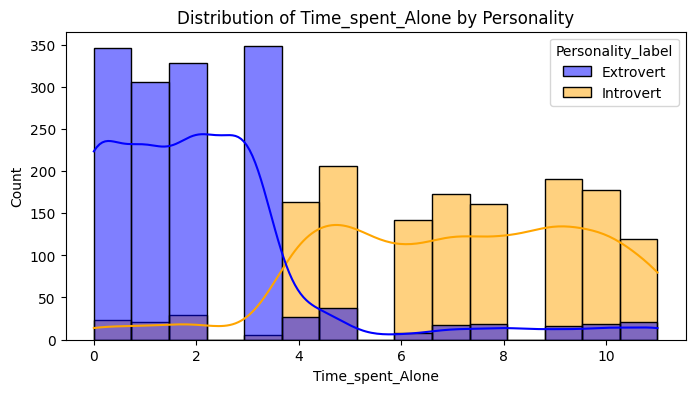

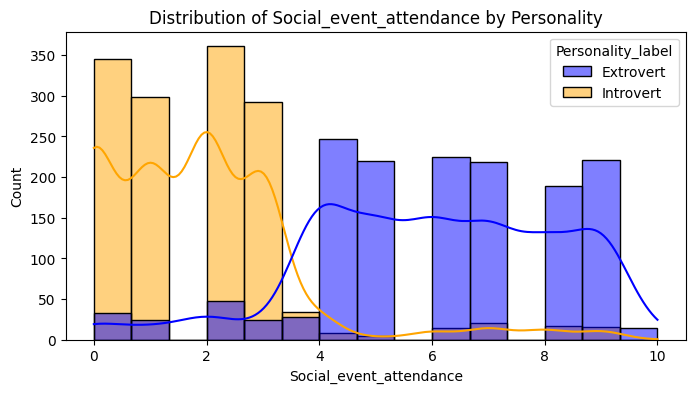

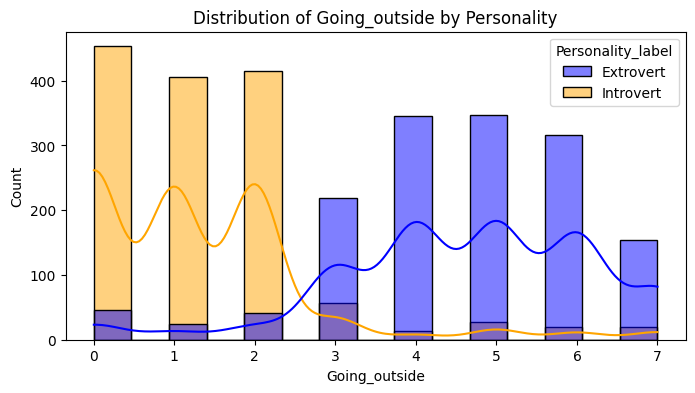

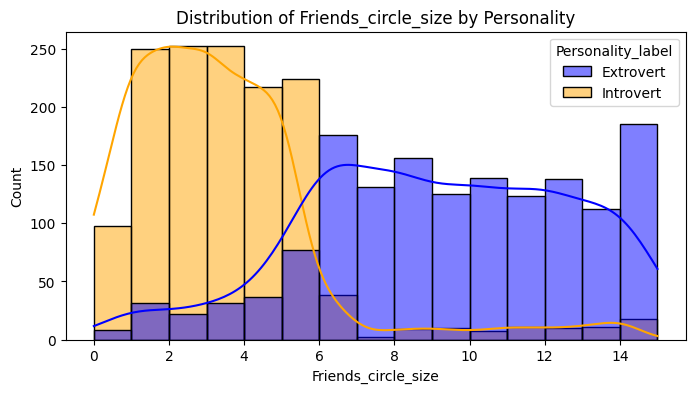

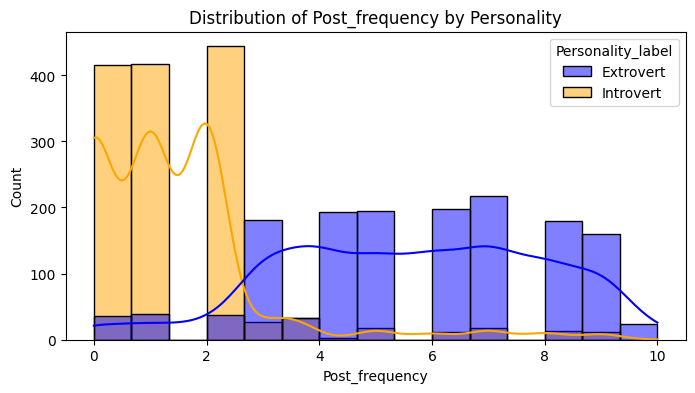

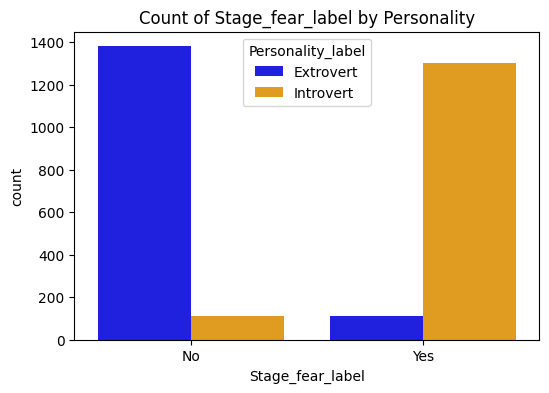

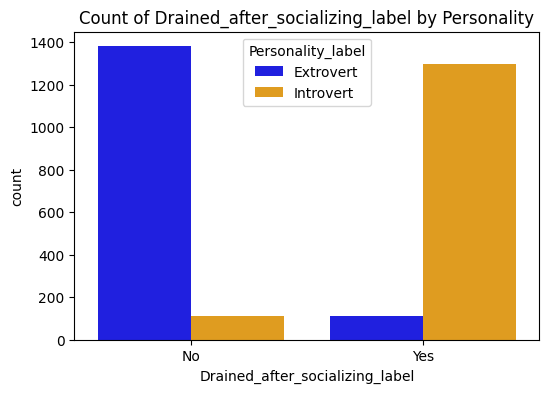

In [273]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numeric features
numeric_features = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
                    'Friends_circle_size', 'Post_frequency']

# Plot histograms
for feature in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=feature, hue='Personality_label', bins=15, kde=True, palette=['blue', 'orange'])
    plt.title(f'Distribution of {feature} by Personality')
    plt.show()

# Plot count plots for binary features
binary_features = ['Stage_fear_label', 'Drained_after_socializing_label']

for feature in binary_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=feature, hue='Personality_label', palette=['blue', 'orange'])
    plt.title(f'Count of {feature} by Personality')
    plt.show()


## Step 4: Prepare Data for Modeling (Split & Scale)

Tasks:
* Split the data into features (X) and target (y).
* Train-test split: Reserve some data for testing the model after training.
* Scale numeric features.

In [274]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop helper columns used for plotting
df = df.drop(columns=['Personality_label', 'Stage_fear_label', 'Drained_after_socializing_label'])

# Define X and y
X = df.drop(columns=['Personality'])
y = df['Personality']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numeric features
numeric_features = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
                    'Friends_circle_size', 'Post_frequency']

scaler = StandardScaler()

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

print("Shapes after split:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


Shapes after split:
X_train: (2320, 7)
X_test: (580, 7)
y_train: (2320,)
y_test: (580,)


## 🧪 Step 5: Train and Compare Multiple Models

Goal: Train a few different models and compare their accuracy side-by-side.
1. Logistic Regression 
2. K-Nearest Neighbors (KNN)
3. Support Vector Machine (SVM)
4. Random Forest
5. XGBoost 

#### 📊 Create helper functions for hyperparameters, and to train and evaluate

In [275]:
# Helper function to train and evaluate
def evaluate_model(name, model, X_train, X_test, y_train, y_test, results):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    results.append((name, acc))

In [276]:
def find_best_k(X_train, y_train, max_k=20):
    k_values = range(1, max_k + 1)
    cv_scores = []

    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())

    best_k = k_values[cv_scores.index(max(cv_scores))]

    return best_k



#### 🚀 Train the models:

In [277]:
results = []

# Logistic Regression (again, for comparison)
evaluate_model("Logistic Regression", LogisticRegression(), X_train, X_test, y_train, y_test, results)

# K-Nearest Neighbors
best_k = find_best_k(X_train, y_train)
evaluate_model("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=21), X_train, X_test, y_train, y_test, results)

# Support Vector Machine
evaluate_model("SVM", SVC(kernel='rbf', gamma='scale'), X_train, X_test, y_train, y_test, results)

# Random Forest
evaluate_model("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42), X_train, X_test, y_train, y_test, results)

# XGBoost (optional)
evaluate_model("XGBoost", xgb.XGBClassifier(eval_metric='logloss'), X_train, X_test, y_train, y_test, results)


Logistic Regression Accuracy: 0.9172
K-Nearest Neighbors Accuracy: 0.9241
SVM Accuracy: 0.9241
Random Forest Accuracy: 0.9086
XGBoost Accuracy: 0.9103


#### 📈 Plot the results:

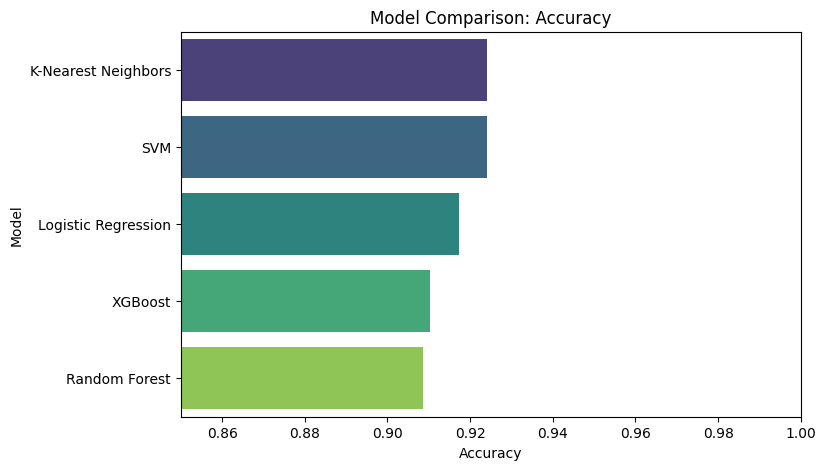

,Model,Accuracy
1,K-Nearest Neighbors,0.924138
2,SVM,0.924138
0,Logistic Regression,0.917241
4,XGBoost,0.910345
3,Random Forest,0.908621


In [278]:
# Turn into DataFrame for comparison
results_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x="Accuracy", y="Model", palette="viridis", hue="Model", legend=False)
plt.title("Model Comparison: Accuracy")
plt.xlim(0.85, 1.00)
plt.show()

results_df

## 🔎 Step 7 — Feature Importance 

### Model 1: Logistic Regression

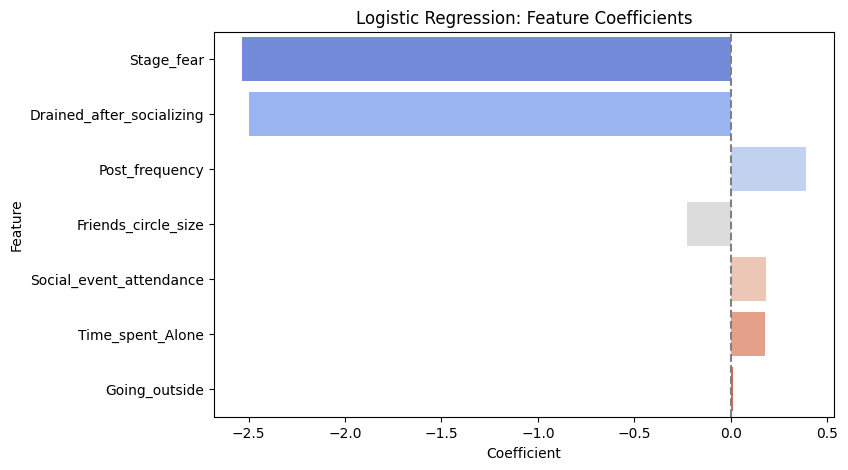

,Feature,Coefficient,Importance (Abs)
1,Stage_fear,-2.534131,2.534131
4,Drained_after_socializing,-2.496593,2.496593
6,Post_frequency,0.389224,0.389224
5,Friends_circle_size,-0.224471,0.224471
2,Social_event_attendance,0.184453,0.184453
0,Time_spent_Alone,0.179190,0.179190
3,Going_outside,0.011731,0.011731


In [279]:
# Refit logistic regression (just to be safe)
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# Get feature names and coefficients
feature_names = X_train.columns
coefficients = log_model.coef_[0]

# Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance (Abs)': abs(coefficients)
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance (Abs)', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df, x='Coefficient', y='Feature', palette='coolwarm', hue='Feature', legend=False)
plt.axvline(0, color='gray', linestyle='--')
plt.title('Logistic Regression: Feature Coefficients')
plt.show()

importance_df


🧠 Key Insights:
* The biggest predictors are emotional/psychological behaviors:
    + Stage fright and post-social exhaustion → classic introvert traits
* Surprisingly:
    + Time_spent_Alone has a positive coefficient — pushing toward extrovert, suggesting extroverts in this dataset also enjoy alone time — or there's multicollinearity.
    + Friends_circle_size slightly negative → might indicate quality over quantity?



### Model 2: Random Forest

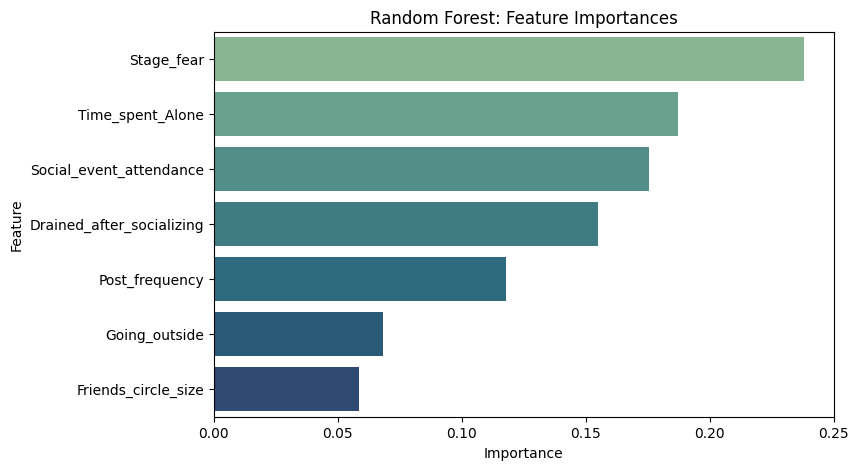

,Feature,Importance
1,Stage_fear,0.238145
0,Time_spent_Alone,0.187170
2,Social_event_attendance,0.175286
4,Drained_after_socializing,0.154786
6,Post_frequency,0.117841
3,Going_outside,0.068242
5,Friends_circle_size,0.058530


In [280]:
# Refit the random forest (just to be safe)
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
rf_importances = rf_model.feature_importances_

rf_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=rf_df, x='Importance', y='Feature', hue='Feature', palette='crest', legend=False)
plt.title('Random Forest: Feature Importances')
plt.show()

rf_df



### Model 3: XGBoost

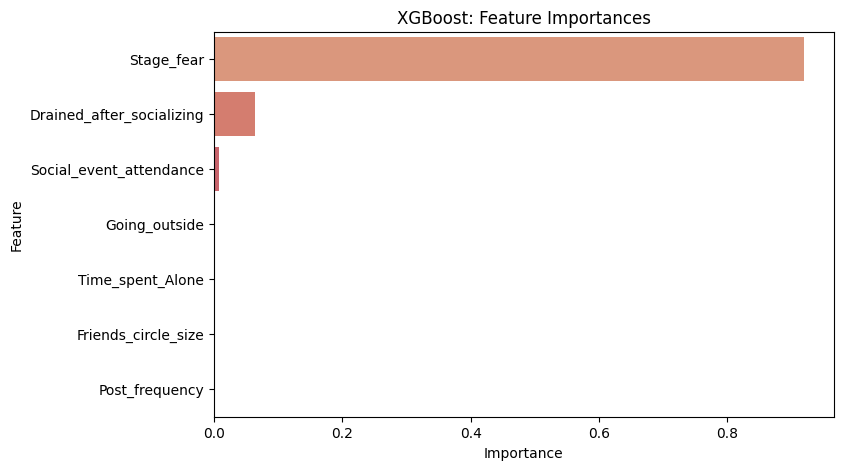

,Feature,Importance
1,Stage_fear,0.920230
4,Drained_after_socializing,0.064544
2,Social_event_attendance,0.008489
3,Going_outside,0.001850
0,Time_spent_Alone,0.001843
5,Friends_circle_size,0.001556
6,Post_frequency,0.001487


In [281]:

xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Extract feature importances
xgb_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=xgb_importances, x='Importance', y='Feature', palette='flare', hue='Feature')
plt.title('XGBoost: Feature Importances')
plt.show()

xgb_importances


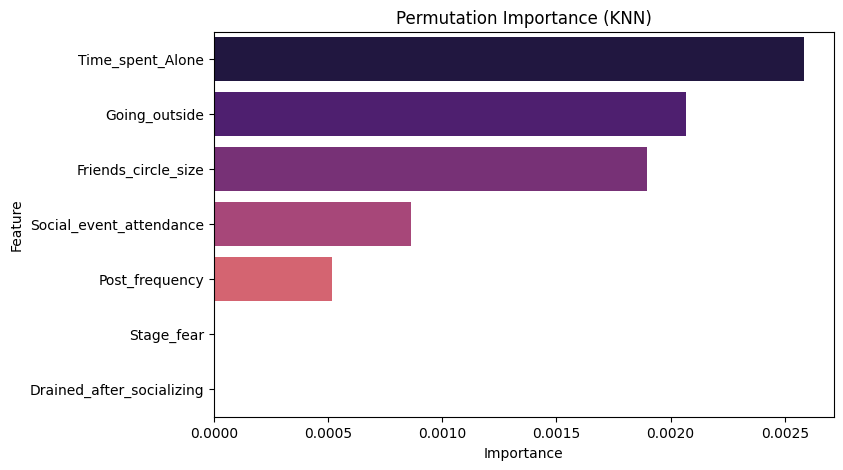

,Feature,Importance
0,Time_spent_Alone,0.002586
3,Going_outside,0.002069
5,Friends_circle_size,0.001897
2,Social_event_attendance,0.000862
6,Post_frequency,0.000517
1,Stage_fear,0.000000
4,Drained_after_socializing,0.000000


In [282]:


knn_model = KNeighborsClassifier(n_neighbors=17)
knn_model.fit(X_train, y_train)

perm_result = permutation_importance(knn_model, X_test, y_test, n_repeats=10, random_state=42)

# Convert to DataFrame
perm_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=perm_df, x='Importance', y='Feature', palette='magma', hue='Feature')
plt.title('Permutation Importance (KNN)')
plt.show()

perm_df


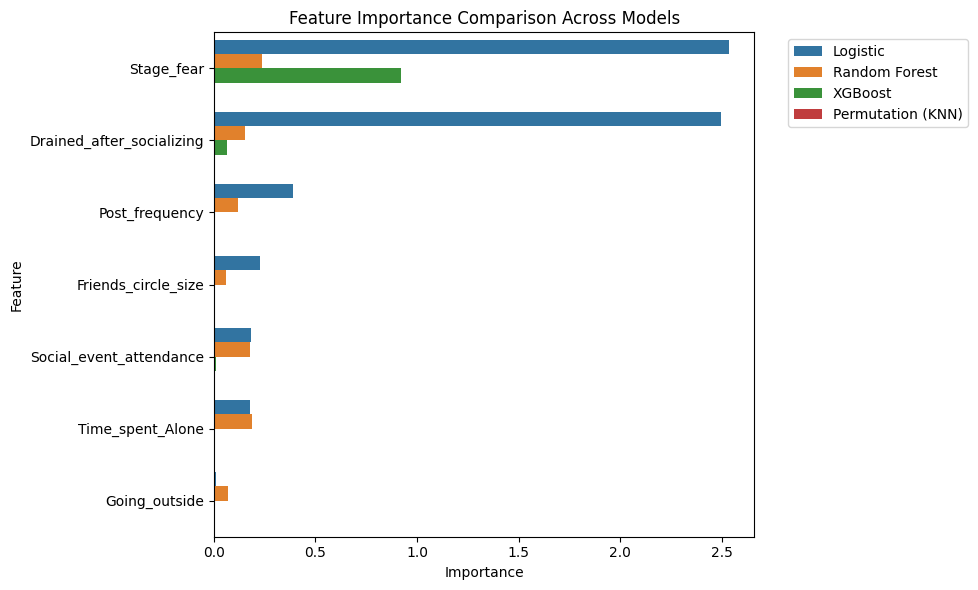

,Feature,Logistic,Random Forest,XGBoost,Permutation (KNN)
0,Stage_fear,2.534131,0.238145,0.920230,0.000000
1,Drained_after_socializing,2.496593,0.154786,0.064544,0.000000
2,Post_frequency,0.389224,0.117841,0.001487,0.000517
3,Friends_circle_size,0.224471,0.058530,0.001556,0.001897
4,Social_event_attendance,0.184453,0.175286,0.008489,0.000862
5,Time_spent_Alone,0.179190,0.187170,0.001843,0.002586
6,Going_outside,0.011731,0.068242,0.001850,0.002069


In [249]:
# Rename columns to match
logreg_df = importance_df[['Feature', 'Importance (Abs)']].rename(columns={'Importance (Abs)': 'Logistic'})
rf_df = rf_df.rename(columns={'Importance': 'Random Forest'})
xgb_df = xgb_importances.rename(columns={'Importance': 'XGBoost'})
perm_df = perm_df.rename(columns={'Importance': 'Permutation (KNN)'})

# Merge all on Feature
combined = logreg_df.merge(rf_df, on='Feature') \
                    .merge(xgb_df, on='Feature') \
                    .merge(perm_df, on='Feature')

# Melt to long format for plotting
melted = combined.melt(id_vars='Feature', var_name='Model', value_name='Importance')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='Importance', y='Feature', hue='Model')
plt.title('Feature Importance Comparison Across Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

combined



# 📊 Final Notes & Interpretation

### 1. **Model Performance Summary**

| Model                        | Accuracy   |
| ---------------------------- | ---------- |
| K-Nearest Neighbors          | **0.9241** |
| Support Vector Machine (SVM) | **0.9241** |
| Logistic Regression          | 0.9172     |
| XGBoost                      | 0.9103     |
| Random Forest                | 0.9086     |

* KNN and SVM tied for the highest accuracy (\~92.4%), showing strong predictive power on this dataset.
* Logistic Regression also performed well (\~91.7%), suggesting that linear relationships exist between features and personality class.
* Tree-based models (Random Forest, XGBoost) showed slightly lower accuracy but still respectable performance.

---

### 2. **Feature Importance Insights**

| Feature                     | Logistic Regression Importance (Abs) | XGBoost Importance | Permutation Importance (KNN) |
| --------------------------- | ------------------------------------ | ------------------ | ---------------------------- |
| Stage\_fear                 | 2.53                                 | 0.92               | 0.00                         |
| Drained\_after\_socializing | 2.50                                 | 0.06               | 0.00                         |
| Post\_frequency             | 0.39                                 | 0.0015             | 0.0005                       |
| Friends\_circle\_size       | 0.22                                 | 0.0016             | 0.0019                       |
| Social\_event\_attendance   | 0.18                                 | 0.0085             | 0.0009                       |
| Time\_spent\_Alone          | 0.18                                 | 0.0018             | 0.0026                       |
| Going\_outside              | 0.01                                 | 0.0019             | 0.0021                       |

* **Stage Fear** and **Drained After Socializing** dominate feature importance in Logistic Regression and XGBoost, emphasizing their strong association with personality type.
* Permutation importance on KNN shows zero for these two features, indicating KNN relies more on a combination of other features or complex nonlinear patterns.
* The remaining features have moderate to low importance but still contribute across models, especially social behavior-related metrics.

---

### 3. **Interpretation**

* **Behavioral indicators** like fear of stage and feeling drained after socializing are key markers that help differentiate introverts from extroverts.
* The KNN model’s zero permutation importance for some features highlights the **differences in how models use information** — KNN’s non-parametric nature captures complex patterns without relying heavily on single features.
* Logistic Regression and XGBoost show more interpretable patterns with clear feature rankings, useful for understanding relationships.

---

### 4. **Limitations & Next Steps**

* The dataset uses self-reported behavioral metrics, which can introduce bias.
* Some features may have nonlinear or interaction effects that simple coefficients don’t capture fully.
* Future work can explore model explainability with SHAP or LIME, try ensembles, or collect more diverse data.
* Additional feature engineering and dimensionality reduction could improve or clarify model insights.

---

### 5. **Project Impact**

* This project demonstrates that **personality traits can be reasonably predicted** from everyday behavioral data.
* It provides a solid foundation for building applications like personality-aware recommendation systems, mental health screening tools, or social behavior analysis platforms.


